In [2]:
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import spacy
from time import time
%matplotlib inline

# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('combined_news.csv')

In [4]:
lengths = []
for article in df.article:
    try:
        lengths.append(len(article))
    except:
        pass
print(len(lengths))

1993065


Statistical Summary of Article Lengths
count    1.993065e+06
mean     3.156440e+03
std      3.467063e+03
min      1.000000e+00
25%      1.075000e+03
50%      2.415000e+03
75%      4.180000e+03
max      1.885260e+05
dtype: float64


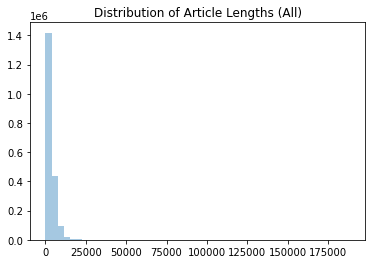

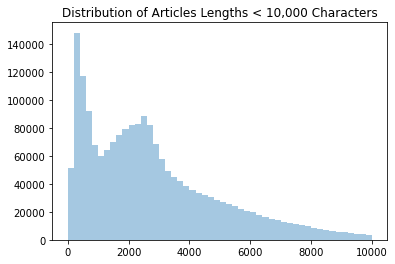

In [5]:
lengths = pd.Series(lengths)
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000],kde=False)
plt.title('Distribution of Articles Lengths < 10,000 Characters')
plt.show()

In [6]:
print(df.bias.value_counts()[df.bias.value_counts()>100][-10:])

least biased    1102982
left-center      640051
left             189016
right             43935
right-center      17081
Name: bias, dtype: int64


In [7]:
biases = df.bias.value_counts()[df.bias.value_counts()>1000][-10:].index.tolist()

In [8]:
biases

['least biased', 'left-center', 'left', 'right', 'right-center']

In [9]:
biased_data = pd.DataFrame()
for bias in biases:
    # select author's data
    articles = df[df.bias==bias][:1000][['title','article','author','bias','publication']]
    # append to DF
    biased_data = biased_data.append(articles)

In [10]:
biased_data = biased_data.reset_index().drop('index',1)

In [11]:
biased_data.head()

,title,article,author,bias,publication
0,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",NaN,least biased,Reuters
1,France's Sarkozy reveals his 'Passions' but in...,PARIS (Reuters) - Former French president Nico...,NaN,least biased,Reuters
2,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",NaN,least biased,Reuters
3,"Venezuela detains six military, police officia...",CARACAS (Reuters) - Venezuelan authorities hav...,NaN,least biased,Reuters
4,Hudson's Bay's chairman's buyout bid pits reta...,(Reuters) - The success of Hudson’s Bay Co Exe...,"Jessica DiNapoli, Harry Brumpton",least biased,Reuters


In [12]:
print('Num of articles: ', biased_data.shape[0])
print('Unique articles: ', len(np.unique(biased_data.index)))

print('')
print('Articles by publication:\n')
print(biased_data.publication.value_counts())

print('')
print('Articles by bias:\n')
print(biased_data.bias.value_counts())

Num of articles:  5000
Unique articles:  5000

Articles by publication:

Vox                 1000
New York Post       1000
Reuters             1000
Fox News            1000
Vice News            621
Business Insider     379
Name: publication, dtype: int64

Articles by bias:

right           1000
least biased    1000
left            1000
left-center     1000
right-center    1000
Name: bias, dtype: int64


In [13]:
lengths = pd.Series([len(x) for x in biased_data.article])

Statistical summary of Article Lengths
count     5000.00000
mean      3862.80400
std       4787.47641
min         52.00000
25%       1450.00000
50%       2803.50000
75%       4636.00000
max      91400.00000
dtype: float64


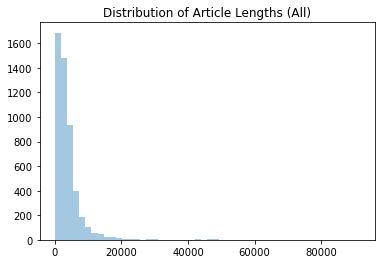

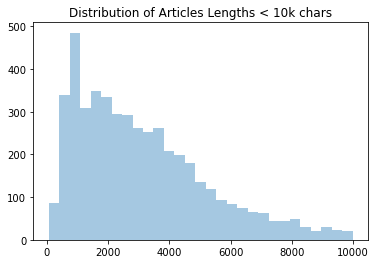

In [14]:
print('Statistical summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths, kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<10000], kde=False)
plt.title('Distribution of Articles Lengths < 10k chars')
plt.show()

In [15]:
t0 = time()

nlp = spacy.load('en')
nlp.max_length = 30000000

common_words = []

# store spacy_doc obj for each author
bias_docs = {}

for bias in biases:
    # corpus is all text by author
    corpus = ""
    # Grab all rows of current author, along 'article'col
    biased_content = biased_data.loc[biased_data.bias==bias, 'article']
    
    # merge all articles in to the author's corpus
    for article in biased_content:
        corpus = corpus + article
    # let spacy parse authpr's body of text
    doc = nlp(corpus)
    
    # store doc in dict
    bias_docs[bias] = doc
    
    #filter out punctuation and stop words
    lemmas = [token.lemma_ for token in doc 
             if not token.is_punct and not token.is_stop]
    
    # return most common words of that bias's corpus
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # add them to the list of words by all authors
    for word in bow:
        common_words.append(word)
    
# eliminate dups
common_words = set(common_words)

print('Total num of common words: ', len(common_words))
print("Done in %0.3fs" % (time() -t0))

Total num of common words:  1804
Done in 2036.599s


In [16]:
lengths = []
for k, v in bias_docs.items():
    print(k, 'corpus contains', len(v), ' words.')
    lengths.append(len(v))

least biased corpus contains 493675  words.
left-center corpus contains 883693  words.
left corpus contains 1285748  words.
right corpus contains 625742  words.
right-center corpus contains 504738  words.


In [24]:
bias_docs = {
    "least biased":bias_docs['leastbiased'],
    "left-center":bias_docs['leftcenter'],
    "left":bias_docs["left"],
    "right": bias_docs["right"],
    "right-center":bias_docs["rightcenter"]
}

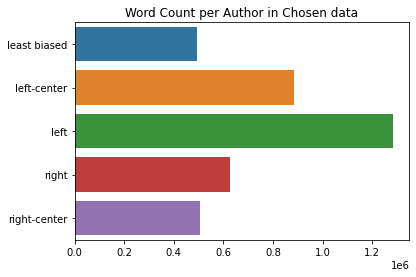

In [21]:
sns.barplot(x=lengths, y=biases, orient='h')
plt.title('Word Count per Author in Chosen data')
plt.show()

In [22]:
common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
print('Count of all common_words: ', len(common_words))
print('Count of lowercase common_words: ', np.sum([word.islower() for word in common_words]))

# turn all common_words into lowercase
common_words  = [ word.lower() for word in common_words]
print('Count of lowercase common_words (After Conversion): ', np.sum([word.islower() for word in common_words]))

Count of all common_words:  1804
Count of lowercase common_words:  1343
Count of lowercase common_words (After Conversion):  1730


In [30]:
if 'author' in common_words:
    common_words.remove('author')
    
if 'title' in common_words:
    common_words.remove('title')
    
if 'article' in common_words:
    common_words.remove('article')
    
if 'bias' in common_words:
    common_words.remove('bias')

In [31]:
bow_counts = pd.DataFrame()
for bias in biases:
    # select X articles of bias
    articles = biased_data.loc[biased_data.bias==bias,:][:1000]
    bow_counts = bow_counts.append(articles)
bow_counts = bow_counts.reset_index().drop('index',1)

# use common_words as cols of temp DF
df = pd.DataFrame(columns=common_words)

# join BOW features w/ authors's content
bow_counts = bow_counts.join(df)

# initialize rows w/ 0s
bow_counts.loc[:, common_words] = 0

# fill df w/ cts of each feature in each article
t0 = time()
for i, article in enumerate(bow_counts.article):
    doc = nlp(article)
    for token in doc:
        if token.lemma_.lower() in common_words:
            bow_counts.loc[i, token.lemma_.lower()] += 1
    # print msg every X articles
    if i% 50 == 0:
        if time() - t0 < 3600: # if less than an hours in seconds
            print("Article ", i, " done after ", (time()-t0)/60, ' minutes')
        else:
            print("Article ", i, " done after ", (time()-t0)/60/60, ' hours')

Article  0  done after  0.0017085790634155274  minutes
Article  50  done after  0.3309415658315023  minutes
Article  100  done after  0.6296736041704813  minutes
Article  150  done after  0.981558616956075  minutes
Article  200  done after  1.3059449791908264  minutes
Article  250  done after  1.5985440254211425  minutes
Article  300  done after  1.9056087096532186  minutes
Article  350  done after  2.203102938334147  minutes
Article  400  done after  2.5444539984067283  minutes
Article  450  done after  2.864805785814921  minutes
Article  500  done after  3.256316089630127  minutes
Article  550  done after  3.5574177900950112  minutes
Article  600  done after  3.919235873222351  minutes
Article  650  done after  4.240600860118866  minutes
Article  700  done after  4.577213700612386  minutes
Article  750  done after  4.8642032345136  minutes
Article  800  done after  5.1565050403277075  minutes
Article  850  done after  5.490057786305745  minutes
Article  900  done after  5.78276286522

In [32]:
bow_counts.head(3)

,title,article,author,bias,publication,opinion,july,\n\n\n\n\n\n\n,year,negotiate,...,farmer,chevron,post,official,kid,operate,criticism,coverage,recode,jones
0,Trump denies report he ordered Mueller fired,"DAVOS, Switzerland (Reuters) - U.S. President ...",NaN,least biased,Reuters,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,France's Sarkozy reveals his 'Passions' but in...,PARIS (Reuters) - Former French president Nico...,NaN,least biased,Reuters,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,"ECB's Coeure: If we decide to cut rates, we'd ...","BERLIN, June 17 (Reuters) - ECB board member B...",NaN,least biased,Reuters,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
bow_counts.to_pickle('bias_bow_counts.pkl')

In [34]:
# bow_counts = pd.read_pickle('bias_bow_counts')

In [35]:
bow_counts.bias.value_counts()

right           1000
least biased    1000
left            1000
left-center     1000
right-center    1000
Name: bias, dtype: int64

In [42]:
# clustering from BOW data

# establish outcome & predictors
y = bow_counts['bias']
X = bow_counts.drop(['article','author', 'title','bias','publication'],1)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                   test_size = 0.24, 
                                                   random_state = 42,
                                                   stratify=y)

In [43]:
X.head()

,opinion,july,\n\n\n\n\n\n\n,year,negotiate,cost,mueller,technology,entire,democracy,...,farmer,chevron,post,official,kid,operate,criticism,coverage,recode,jones
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,5,2,0,0,0,0,0,...,0,0,0,0,0,2,1,0,0,0


In [44]:
# make sure classes are balanced after split
y_test.value_counts()

least biased    240
left-center     240
right           240
right-center    240
left            240
Name: bias, dtype: int64

In [45]:
# DF to store results

# for clustering algos, test/train and cross_val will be blank, as clustering requires no test/train split. 

# store results in a DataFrame
metrics = ['Algorithm', 'n_train', 'Features', 'ARI', 'Homogeneity',
          'Silhouette', 'Mutual_Info', 'Vross_val', 'Train_accuracy',
          'Test_accuracy']
performance = pd.DataFrame(columns=metrics)

In [46]:

def evaluate_clust(clust, params, features, i):
    t0 = time()
    print('\n','-'*40, '\n', clust.__class__.__name__, '\n', '-'*40)
    
    # find best params based on scoring of choice
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clust, params, scoring=score, cv=3).fit(X,y)
    print("Best params: ", search.best_params_)
    y_pred = search.best_estimator_.fit_predict(X)
    print(y_pred)
    
    ari = adjusted_rand_score(y, y_pred)
    performance.loc[i, 'ARI'] = ari
    print(f"Adjusted Rand-Index: {ari:.3f}")
    
    hom = homogeneity_score(y, y_pred)
    performance.loc[i, 'Homogeneity'] = hom
    print(f'Homogeneity Score: {hom:.3f}')
    
    sil = silhouette_score(X, y_pred)
    performance.loc[i, 'Silhouette'] = sil
    print(f"Silhouette Score: {sil:.3f}")
    
    nmi = normalized_mutual_info_score(y, y_pred)
    performance.loc[i, 'Mutual_Info'] = nmi
    print(f"Normalized Mutual-Info Score: {nmi:.3f}")
    
    performance.loc[i, 'n_train'] = len(X)
    performance.loc[i, 'Features'] = features
    performance.loc[i, 'Algorithm'] = clust.__class__.__name__
    
    # print contingency matrix
    crosstab = pd.crosstab(y, y_pred)
    plt.figure(figsize=(8,5))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()
    print(time()-t0, ' seconds.')


 ---------------------------------------- 
 KMeans 
 ----------------------------------------
Best params:  {'init': 'random', 'n_clusters': 20, 'n_init': 20, 'precompute_distances': False}
[4 7 4 ... 4 4 4]
Adjusted Rand-Index: 0.078
Homogeneity Score: 0.215
Silhouette Score: 0.071
Normalized Mutual-Info Score: 0.190


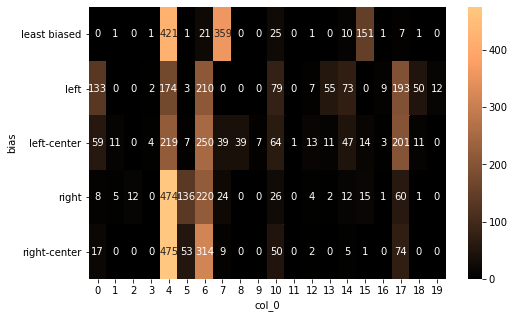

391.32459807395935  seconds.


In [47]:
# kmeans bow
clust = KMeans()
params = {
    'n_clusters': np.arange(10, 30, 5),
    'init': ['k-means++', 'random'],
    'n_init': [10,20],
    'precompute_distances': [True, False]
}
evaluate_clust(clust, params, features='BOW', i=0)


 ---------------------------------------- 
 MeanShift 
 ----------------------------------------
Best params:  {}
[0 0 0 ... 0 0 0]
Adjusted Rand-Index: 0.015
Homogeneity Score: 0.198
Silhouette Score: 0.218
Normalized Mutual-Info Score: 0.187


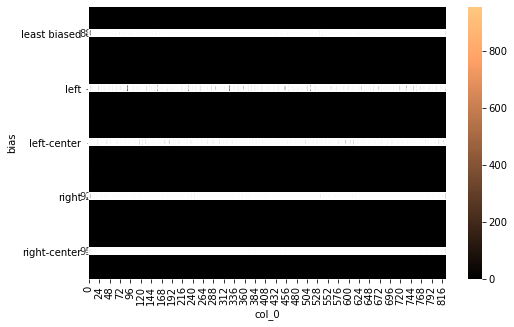

2678.626798391342  seconds.


In [48]:
# mean shift BOW
# declare and fit
clust = MeanShift()

params = {}
evaluate_clust(clust, params, features='BOW', i=1)


 ---------------------------------------- 
 AffinityPropagation 
 ----------------------------------------
Best params:  {'damping': 0.9, 'max_iter': 500}
[899  25 899 ... 324 901 901]
Adjusted Rand-Index: 0.018
Homogeneity Score: 0.377
Silhouette Score: -0.039
Normalized Mutual-Info Score: 0.194


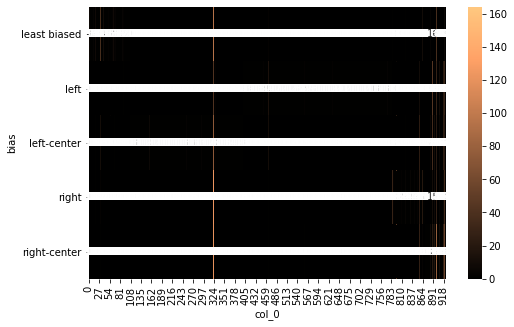

609.0424695014954  seconds.


In [49]:
# affinity propagation CBOW
# declare and fit the model
clust = AffinityPropagation()

params = {
    'damping': [0.5, 0.7, 0.9],
    'max_iter': [200, 500]
}

evaluate_clust(clust, params, features="BOW", i=2)

Adjusted Rand-Index: 0.000
Homogeneity Score: 0.000
Normalized Mutual-Info Score: 0.000


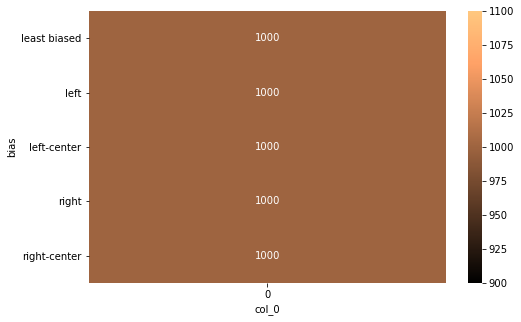

5818.187667608261  seconds.


In [51]:
# spectral clustering CBOW
# can't use .fit
clust = SpectralClustering()
params={
    'n_clusters': np.arange(10,26, 5),
    # 'eigen_solver': ['arpack', 'lobpcg', None],
    'n_init':[15, 25],
    'assign_labels': ['kmeans', 'discretize']
}

features = 'BOW'

i = 3
t0 = time()

y_pred = clust.fit_predict(X)

ari = adjusted_rand_score(y, y_pred)
performance.loc[i, 'ARI'] = ari
print(f"Adjusted Rand-Index: {ari:.3f}")

hom = homogeneity_score(y, y_pred)
performance.loc[i, 'Homogeneity'] = hom
print(f'Homogeneity Score: {hom:.3f}')

# sil = silhouette_score(X, y_pred)
# performance.loc[i, 'Silhouette'] = sil
# print(f"Silhouette Score: {sil:.3f}")

nmi = normalized_mutual_info_score(y, y_pred)
performance.loc[i, 'Mutual_Info'] = nmi
print(f"Normalized Mutual-Info Score: {nmi:.3f}")

performance.loc[i, 'n_train'] = len(X)
performance.loc[i, 'Features'] = features
performance.loc[i, 'Algorithm'] = clust.__class__.__name__

# print contingency matrix
crosstab = pd.crosstab(y, y_pred)
plt.figure(figsize=(8,5))
sns.heatmap(crosstab, annot=True, fmt='d', cmap=plt.cm.copper)
plt.show()
print(time()-t0, ' seconds.')

In [52]:
performance.iloc[:,:7]

,Algorithm,n_train,Features,ARI,Homogeneity,Silhouette,Mutual_Info
0,KMeans,5000,BOW,0.0775894,0.214991,0.0713989,0.18951
1,MeanShift,5000,BOW,0.0153869,0.197838,0.217717,0.186796
2,AffinityPropagation,5000,BOW,0.0182463,0.376907,-0.039098,0.193574
3,SpectralClustering,5000,BOW,0,0,NaN,0


In [53]:
def score_optimization(clf, params, features, i):
    t0 = time()
    #heading
    print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)
    # find best params based on sorting of choices
    score = make_scorer(normalized_mutual_info_score)
    search = GridSearchCV(clf, params, scoring=score, cv=3).fit(X,y)
    
    #extract best estimator
    best = search.best_estimator_
    print("Best params: ", search.best_params_)
    
    # cross-validate on all the data
    cv = cross_val_score(X=X, y=y, estimator=best, cv=5)
    print("\nCross-val scores(All Data): ", cv)
    print("Mean cv score: ", cv.mean())
    performance.loc[i, 'Cross_Val'] = cv.mean()
    
    # get train accuracy
    best = best.fit(X_train, y_train)
    train = best.score(X=X_train, y=y_train)
    performance.loc[i, 'Train_Accuracy'] = train
    print("\nTrain Accuracy Score: ", train)
    
    # get test acc
    test = best.score(X=X_test, y=y_test)
    performance.loc[i, 'Test_Acc'] = test
    print("\nTest Acc Score: ", test)
    
    y_pred = best.predict(X_test)
    
    ari = adjusted_rand_score(y_test, y_pred)
    performance.loc[i, "ARI"] = ari
    print(f"\nAdjusted Rand-Index: {ari:.3f}")
    
    hom = homogeneity_score(y_test, y_pred)
    performance.loc[i, "Homogeneity"] = hom
    print(f"Homogeneity score: {hom:.3f}")
    
    sil = silhouette_score(X_test, y_pred)
    performance.loc[i, 'Silhouette'] = sil
    print(f"Silhouette score: {sil: .3f}")
    
    nmi = normalized_mutual_info_score(y_test, y_pred)
    performance.loc[i, 'Mutual_Info'] = nmi
    print(f"Normed mutual-info score: {nmi:.3f}")
    
    print(classification_report(y_test, y_pred))
    
    conf_matrix = pd.crosstab(y_test, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()
    
    performance.loc[i,'train'] = len(X_train)
    performance.loc[i, 'Features'] = features
    performance.loc[i, 'Algorithm'] = clf.__class__.__name__
    print(time() - t0, 'seconds')


 ---------------------------------------- 
 LogisticRegression 
 ----------------------------------------
Best params:  {'C': 0.3, 'penalty': 'l1', 'solver': 'liblinear'}

Cross-val scores(All Data):  [0.858 0.867 0.854 0.861 0.835]
Mean cv score:  0.8550000000000001

Train Accuracy Score:  0.9678947368421053

Test Acc Score:  0.8516666666666667

Adjusted Rand-Index: 0.676
Homogeneity score: 0.662
Silhouette score: -0.117
Normed mutual-info score: 0.662
              precision    recall  f1-score   support

least biased       0.96      0.98      0.97       240
        left       0.90      0.86      0.88       240
 left-center       0.79      0.75      0.77       240
       right       0.87      0.86      0.87       240
right-center       0.74      0.80      0.77       240

    accuracy                           0.85      1200
   macro avg       0.85      0.85      0.85      1200
weighted avg       0.85      0.85      0.85      1200



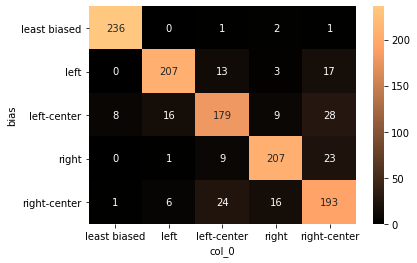

947.4585845470428 seconds


In [54]:
params = [
    {
        'solver': ['newton-cg', 'lbfgs', 'sag'],
        'C': [0.3, 0.5, 0.7, 1.0],
        'penalty':['l2']
    },
    {
        'solver': ['liblinear', 'saga'],
        'C': [0.3, 0.5, 0.7, 1.0],
        'penalty':['l1','l2']
    }
]

clf = LogisticRegression(n_jobs =-1)  # use all CPU

score_optimization(clf=clf, params=params, features="BOW", i=4)